In [16]:
# Data processing
import os 
from pathlib import Path

# Training and validation
from sklearn.model_selection import train_test_split

# Pre-processing
from PIL import Image

# model
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.layers import *
from keras.models import *
from keras.preprocessing import image


## Pre Processing images

In [17]:
# I think we have enought images, if not we do image augmentation
train_datagen = image.ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
)
test_dataset = image.ImageDataGenerator(rescale=1/255)

In [18]:


git_dir = Path().parent.absolute().parent

train_dir = os.path.join(git_dir, 'data\\train\\',)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'binary'
    )

test_dir = os.path.join(git_dir, 'data\\test\\',)
test_generator = test_dataset.flow_from_directory(
    test_dir,
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'binary'
    )

Found 19486 images belonging to 2 classes.
Found 9599 images belonging to 2 classes.


In [19]:
train_generator.class_indices

{'live': 0, 'spoof': 1}

## Model 

In [20]:
# Using as a base model
# https://medium.com/@mayankverma05032001/binary-classification-using-convolution-neural-network-cnn-model-6e35cdf5bdbb

model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3),activation='ReLU', input_shape=(224,224, 3))) # Need to check the mean size of the pictures for better performance

model.add(Conv2D(64,(3,3), activation='ReLU'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,(3,3), activation='ReLU'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(64,activation='ReLU'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss=keras.losses.binary_crossentropy, optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 64)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 110, 110, 64)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                    

In [21]:
%%time

steps = train_generator.samples / train_generator.batch_size
steps = round(steps)

history = model.fit_generator(
    train_generator,
    steps_per_epoch = steps,
    epochs = 10,
    validation_data = train_generator,
    validation_steps = 2
)

<timed exec>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/10
609/609 [==============================] - 2013s 3s/step - loss: 0.5081 - accuracy: 0.7714 - val_loss: 0.5383 - val_accuracy: 0.7656
Epoch 2/10
609/609 [==============================] - 1932s 3s/step - loss: 0.4007 - accuracy: 0.8398 - val_loss: 0.2412 - val_accuracy: 0.8906
Epoch 3/10
609/609 [==============================] - 1812s 3s/step - loss: 0.3670 - accuracy: 0.8577 - val_loss: 0.2608 - val_accuracy: 0.9062
Epoch 4/10
609/609 [==============================] - 3348s 5s/step - loss: 0.3380 - accuracy: 0.8693 - val_loss: 0.3373 - val_accuracy: 0.8906
Epoch 5/10
609/609 [==============================] - 3025s 5s/step - loss: 0.3089 - accuracy: 0.8835 - val_loss: 0.2170 - val_accuracy: 0.9375
Epoch 6/10
609/609 [==============================] - 3167s 5s/step - loss: 0.2909 - accuracy: 0.8932 - val_loss: 0.3138 - val_accuracy: 0.8750
Epoch 7/10
609/609 [==============================] - 2918s 5s/step - loss: 0.2728 - accuracy: 0.8992 - val_loss: 0.2294 - val_accuracy:

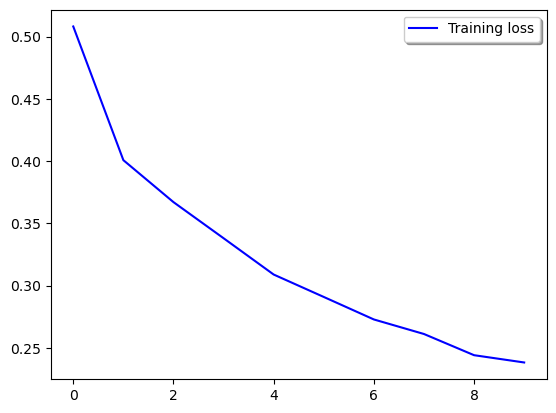

In [22]:
#Vamos ver como foi o treino?
import matplotlib.pyplot as plt
import joblib


plt.plot(history.history['loss'], color='b', label="Training loss")
legend = plt.legend(loc='best', shadow=True)



In [23]:
model.evaluate(test_generator)

300/300 [==============================] - 723s 2s/step - loss: 0.3070 - accuracy: 0.8469


[0.3069630563259125, 0.8468590378761292]

In [24]:
# save the model to disk
filename = 'models/CNN.keras'
# Calling `save('my_model.keras')` creates a zip archive `my_model.keras`.
model.save(filename)



In [25]:
import tensorflow.keras as keras
import numpy as np
from pathlib import Path
import os

In [26]:

git_dir = Path().parent.absolute().parent
filename = os.path.join(git_dir,'models/CNN.keras')

# It can be used to reconstruct the model identically.
reconstructed_model = keras.models.load_model(filename)

try:
    np.testing.assert_allclose(
        model.predict(test_generator), reconstructed_model.predict(test_generator)
    )
except Exception as e:
    print(e)

300/300 [==============================] - 305s 1s/step

Not equal to tolerance rtol=1e-07, atol=0

Mismatched elements: 9599 / 9599 (100%)
Max absolute difference: 0.99999845
Max relative difference: 3.0058533e+20
 x: array([[0.040583],
       [0.013542],
       [0.98801 ],...
 y: array([[0.975659],
       [0.999125],
       [0.93197 ],...


In [27]:
reconstructed_model.predict()

TypeError: predict() missing 1 required positional argument: 'x'